In [1]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_path = 'gs://my-project-bucket-px/cleaned/cleaned_matchdata.parquet'
parquet_df = spark.read.parquet(file_path)

sdf = spark.createDataFrame(parquet_df.rdd, parquet_df.schema)

In [ ]:
# Split the data into training and test sets
trainingData, testData = sdf.randomSplit([0.70, 0.3], seed=42)

feature_cols = [
    "hp",
    "armor",
    "equipmentValue",
    "hasHelmet",
    "num_enemy_alive",
    "num_team_alive",
    "enemy_in_range_2000",
    "team_in_range_500",
    "hp_closest_enemy"
]

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = MinMaxScaler(inputCol='features', outputCol="featuresScaled")

# Create a Linear Regression Estimator
linear_reg = LinearRegression(featuresCol='featuresScaled', labelCol='isDead')

# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='isDead')

# Create the pipeline   Indexer is stage 0 and Linear Regression (linear_reg)  is stage 3
regression_pipe = Pipeline(stages=[assembler, scaler, linear_reg])

# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()
grid = grid.addGrid(linear_reg.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(linear_reg.elasticNetParam, [0, 0.5, 1])
grid = grid.build()

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=regression_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)

# Train the models
all_models  = cv.fit(trainingData)

# Show the average performance over the three folds
print(f"Average metric {all_models.avgMetrics}")

# Get the best model from all of the models trained
bestModel = all_models.bestModel

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)
# Show the predicted tip
test_results.select('hp', 'armor', 'equipmentValue', 'hasHelmet', 'num_enemy_alive', 'num_team_alive',
                    'enemy_in_range_2000', 'team_in_range_500', 'hp_closest_enemy', 'isDead', 'prediction').show(truncate=False)
# Calculate RMSE and R2
rmse = evaluator.evaluate(test_results, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

In [5]:
model_path = "gs://my-project-bucket-px/models/csgo_linear_regression_model1"
bestModel.write().overwrite().save(model_path)

trust_path = "gs://my-project-bucket-px/trusted/matchdataFeatures1.parquet"
test_results.write.parquet(trust_path)

In [2]:
file_path = 'gs://my-project-bucket-px/trusted/matchdataFeatures1.parquet/part-00001-5522ee91-144e-4588-a6a4-30460599011e-c000.snappy.parquet'
parquet_df = spark.read.parquet(file_path)

test_results = spark.createDataFrame(parquet_df.rdd, parquet_df.schema)
test_results = test_results.sample(False, 0.1)

In [ ]:
df = test_results.select('team_in_range_500', 'prediction', 'equipmentValue').sample(False, 0.20).toPandas()
sns.set_style("white")

# Create the relationship plot
relationship_plot = sns.lmplot(x='team_in_range_500', hue='prediction', data=df, kind="kde")



<Axes: >

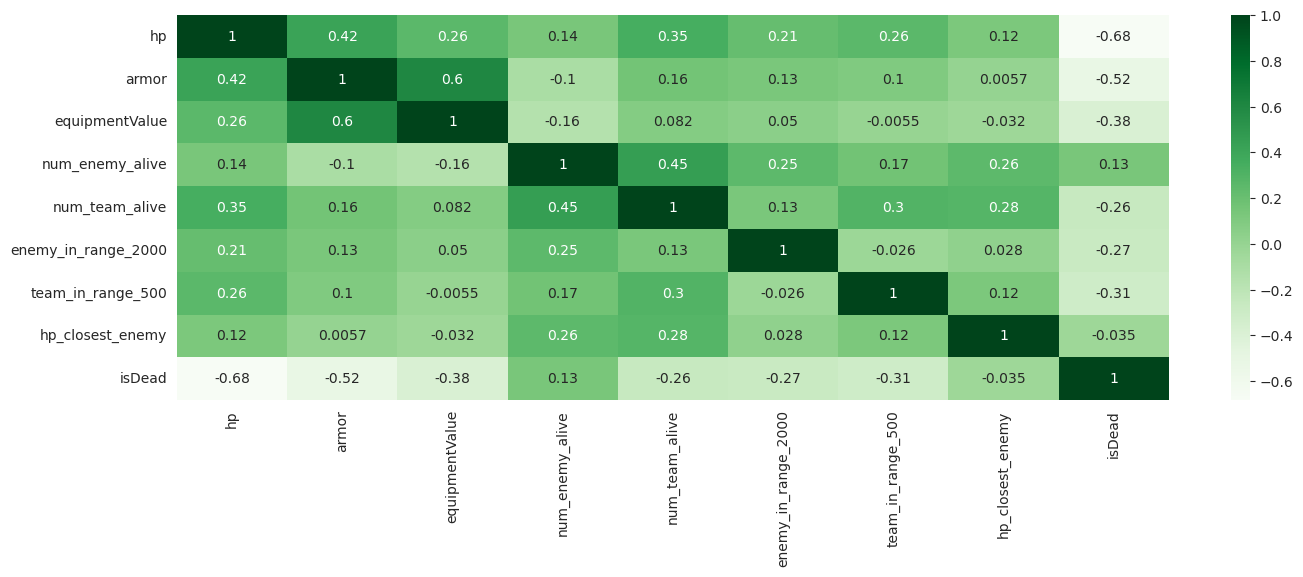

In [13]:
# correlation Matrix of features

# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Choose the numeric (Double) columns 
numeric_columns = [
    "hp",
    "armor",
    "equipmentValue",
    "num_enemy_alive",
    "num_team_alive",
    "enemy_in_range_2000",
    "team_in_range_500",
    "hp_closest_enemy",
    "isDead"]
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf).select(vector_column)

# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 

heatmap_plot = plt.figure(figsize=(16,5))  
# Set the style for Seaborn plots
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)

<Figure size 1200x600 with 0 Axes>

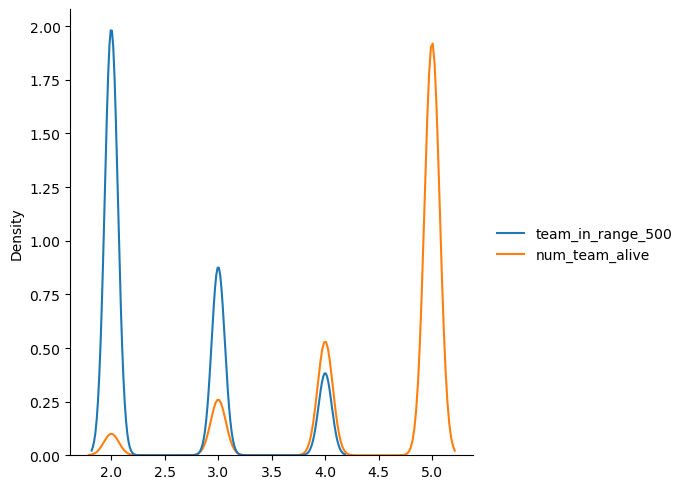

In [3]:
# Distribution Plot
results_team = test_results.where((test_results['num_team_alive'] > 1) & (test_results['num_team_alive'] < 5))
results_team = test_results.where((test_results['team_in_range_500'] > 1) & (test_results['team_in_range_500'] < 5))

df = results_team.select('team_in_range_500', 'num_team_alive').toPandas()

plt.figure(figsize=(12, 6))
sns.displot(data=df, kind='kde')


In [ ]:
# barchart of average features by outcome

df = test_results.select('prediction', 'num_team_alive').toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='prediction', y='num_team_alive', data=df, estimator=np.mean)
plt.title('Average Number of Teammates Alive by Outcome')
plt.xlabel('Outcome (0: Survived, 1: Died)')
plt.ylabel('Average Number of Enemies Alive')
plt.show()


In [ ]:
df = test_results.select('prediction', 'hp_closest_enemy', 'isDead').toPandas()

plt.figure(figsize=(10, 6))
sns.lmplot(x='hp_closest_enemy', y='prediction', data=df, hue='isDead', scatter_kws={'alpha':0.5})

